# Neural Network with Pytorch

In [31]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import pandas as pd
import numpy as np
import sklearn.datasets

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


torch.manual_seed(0)

# Define dataloader

In [32]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return self.y.size()[0]

# Preparing Data

In [33]:
from sklearn.model_selection import train_test_split


data = pd.read_csv("TrainData.csv").drop(["Unnamed: 0"],axis=1)
X = data.drop(["salary_label"],axis=1)
y = data["salary_label"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_tensor_train = torch.from_numpy(np.asarray(X_train_scaled)).float()
y_tensor_train = torch.from_numpy(np.asarray(y_train)).float()
train_set = MyDataset(X_tensor_train, y_tensor_train)

X_tensor_test = torch.from_numpy(np.asarray(X_test_scaled)).float()
y_tensor_test = torch.from_numpy(np.asarray(y_test)).float()
test_set = MyDataset(X_tensor_test, y_tensor_test)

# Setting up NN model

In [34]:
inputDim = X.shape[1]
outputDim = 4

class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)

        return x

# Training up to 80 epochs

In [41]:
model = NeuralNetwork(inputDim, 64, outputDim)
dataloader = DataLoader(train_set, batch_size = 50, shuffle = True)
learningRate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

epochs = 80

test_acc_history = []
test_loss = []
train_history = []

for epoch in range(epochs):
    losses = []
    train_accuracy = []
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        
        output = model(x_batch)
        loss = criterion(output, y_batch.to(dtype=torch.long))
        loss.backward()
        losses.append(loss.item())
        train_accuracy.append(accuracy_score(y_batch.to(dtype=torch.long), np.argmax(output.detach().numpy(), axis = 1)))
        
        optimizer.step()
    
    print('epoch {}, loss {}, train accuracy {}'.format(epoch, np.mean(losses), np.mean(train_accuracy)))
    train_history.append(np.mean(train_accuracy))
    
    if epoch >= 0:
        with torch.no_grad():
            out_test = model(X_tensor_test)
            test_accuracy = accuracy_score(np.argmax(out_test.numpy(), axis=1), y_test)
            loss = criterion(out_test, y_tensor_test.to(dtype=torch.long))
        print("Validation accuracy: {}, Validation loss: {}".format(test_accuracy, loss.numpy()))
        test_acc_history.append(test_accuracy)
        test_loss.append(loss)

epoch 0, loss 1.361448938647906, train accuracy 0.30471064814814813
Validation accuracy: 0.325, Validation loss: 1.3460615873336792
epoch 1, loss 1.3293718033366733, train accuracy 0.3335300925925926
Validation accuracy: 0.3675, Validation loss: 1.3284540176391602
epoch 2, loss 1.2970204883151584, train accuracy 0.36188657407407404
Validation accuracy: 0.3575, Validation loss: 1.332187533378601
epoch 3, loss 1.282292741868231, train accuracy 0.37572916666666667
Validation accuracy: 0.37, Validation loss: 1.3211382627487183
epoch 4, loss 1.2678789248069127, train accuracy 0.39168981481481474
Validation accuracy: 0.355, Validation loss: 1.3222029209136963
epoch 5, loss 1.2594165255626042, train accuracy 0.400787037037037
Validation accuracy: 0.3475, Validation loss: 1.320587158203125
epoch 6, loss 1.2472811804877386, train accuracy 0.4077083333333333
Validation accuracy: 0.36, Validation loss: 1.3125050067901611
epoch 7, loss 1.2379982935057745, train accuracy 0.41077546296296297
Validat

epoch 62, loss 0.928014294968711, train accuracy 0.5922222222222222
Validation accuracy: 0.375, Validation loss: 1.5427350997924805
epoch 63, loss 0.9256936800148752, train accuracy 0.5911574074074074
Validation accuracy: 0.3825, Validation loss: 1.553025484085083
epoch 64, loss 0.9258563816547394, train accuracy 0.5885995370370372
Validation accuracy: 0.3675, Validation loss: 1.5656856298446655
epoch 65, loss 0.9210210906134711, train accuracy 0.5872106481481482
Validation accuracy: 0.375, Validation loss: 1.5688437223434448
epoch 66, loss 0.9162789616319869, train accuracy 0.5961342592592592
Validation accuracy: 0.3675, Validation loss: 1.5594438314437866
epoch 67, loss 0.9166237513224283, train accuracy 0.5880671296296296
Validation accuracy: 0.3575, Validation loss: 1.5870883464813232
epoch 68, loss 0.9104893066816859, train accuracy 0.5969907407407408
Validation accuracy: 0.37, Validation loss: 1.5828264951705933
epoch 69, loss 0.913015735646089, train accuracy 0.5930208333333334


# General performance on train/validation data set

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

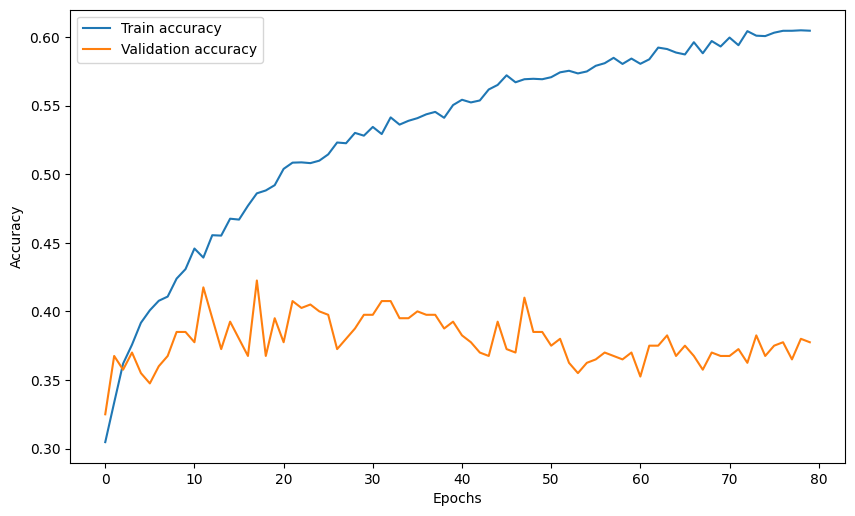

In [42]:
fig = plt.figure(figsize = (10,6), dpi = 100)
plt.plot(train_history, label = "Train accuracy")
plt.plot(test_acc_history, label = "Validation accuracy")
plt.legend()
plt.gca().set(xlabel = "Epochs",ylabel = "Accuracy")

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

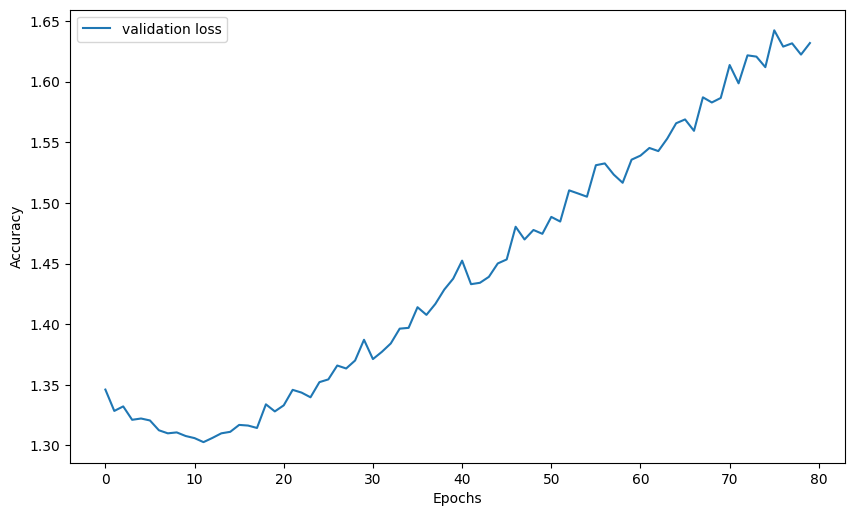

In [44]:
fig = plt.figure(figsize = (10,6), dpi = 100)
plt.plot(test_loss, label = "validation loss")
plt.legend()
plt.gca().set(xlabel = "Epochs",ylabel = "Accuracy")

# Final test on test data

In [55]:
from sklearn.metrics import accuracy_score
df = pd.read_csv("TestData.csv")

X_train = X
y_train = y

X_test = df.drop(["salary_label","Unnamed: 0"],axis=1)
y_test = df["salary_label"]


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = NeuralNetwork(inputDim, 64, outputDim)
for epoch in range(4):
    losses = []
    train_accuracy = []
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch.to(dtype=torch.long))
        loss.backward()
        losses.append(loss.item())
        train_accuracy.append(accuracy_score(y_batch.to(dtype=torch.long), np.argmax(output.detach().numpy(), axis = 1)))
        optimizer.step()


y_pred = model(torch.from_numpy(X_test).float())

y_pred_class = torch.argmax(y_pred, dim=1)

test_acc = accuracy_score(y_test,y_pred_class.detach().numpy())

print("=======Accuracy on test data set=======")
print(test_acc)

=======Accuracy on test data set=======
0.272
